<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Object-detection/blob/main/Object_detection_with_Vision_Transformers_(ViT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple Keras implementation of object detection using Vision Transformers

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 11/07/2024
<br>
**Reference:**

- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://doi.org/10.48550/arXiv.2010.11929)

- [Keras Example](https://keras.io/examples/vision/object_detection_using_vision_transformer/)

## Introduction

The Vision Transformer (ViT) architecture, introduced by Alexey Dosovitskiy et al., marks a significant shift in the landscape of computer vision. Unlike traditional convolutional neural networks (CNNs), which have been the cornerstone of image processing tasks, ViTs leverage the transformer architecture, originally designed for natural language processing. This architecture applies a pure transformer directly to sequences of image patches, bypassing convolutions entirely.

The success of ViTs is rooted in their ability to capture long-range dependencies in images through self-attention mechanisms, offering a new paradigm for understanding and processing visual data. This has led to impressive performance on a variety of tasks, including image classification, segmentation, and object detection.

In this Keras example, we implement an object detection model based on the ViT architecture and train it on the Caltech 101 dataset. The objective is to detect airplanes in given images, showcasing the efficacy of ViTs in handling object detection tasks. By leveraging the inherent strengths of transformers, we aim to achieve competitive performance while exploring the potential benefits and challenges of this innovative approach.


## Imports and Setup

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

## Prepare Dataset

In [3]:
# Path to images and annotations
path_images = './101_ObjectCategories/airplanes/'
path_annot = './Annotations/Airplanes_Side_2/'

path_to_downloaded_file = keras.utils.get_file(
    fname='caltech_101_zipped',
    origin='https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip',
    extract=True,
    archive_format='zip',
    cache_dir='/',
)

download_base_dir = os.path.dirname(path_to_downloaded_file)

137414764/137414764 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
# Exracting tar files from main zip file
shutil.unpack_archive(
    os.path.join(download_base_dir, 'caltech-101', '101_ObjectCategories.tar.gz')
)

shutil.unpack_archive(
    os.path.join(download_base_dir, 'caltech-101', 'Annotations.tar'), '.'
)

In [5]:
# List of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]

annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
image_paths.sort()

image_size = 224

images, targets = [], []

In [6]:
# Loop over the annotations and images, Preprocess them and Store in lists
for i in range(0, len(annot_paths)):
  annot = scipy.io.loadmat(path_annot + annot_paths[i])['box_coord'][0]

  top_left_x, top_left_y = annot[2], annot[0]
  bottom_right_x, bottom_right_y = annot[3], annot[1]

  image = keras.utils.load_img(
      path_images + image_paths[i],
  )
  (w, h) = image.size[:2]

  image = image.resize((image_size, image_size))

  images.append(keras.utils.img_to_array(image))

  targets.append(
      (
          float(top_left_x) / w,
          float(top_left_y) / h,
          float(bottom_right_x) / w,
          float(bottom_right_y) / h,
      )
  )

In [7]:
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)

(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

## Implement Multi-Layer-Perceptron (MLP)

In [8]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

## Implement the Patch creation layer

In [9]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    input_shape = ops.shape(images)
    batch_size = input_shape[0]
    height = input_shape[1]
    width = input_shape[2]
    channels = input_shape[3]
    num_patches_h = height // self.patch_size
    num_patches_w = width // self.patch_size
    patches = keras.ops.image.extract_patches(images, size=self.patch_size)
    patches = ops.reshape(
        patches,
        (
            batch_size,
            num_patches_h * num_patches_w,
            self.patch_size * self.patch_size * channels
        ),
    )
    return patches

  def get_config(self):
    config = super().get_config()
    config.update({'patch_size': self.patch_size})
    return config

## Display patches for an input image

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


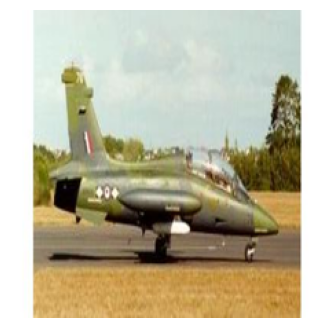

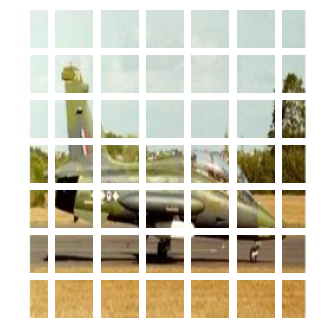

In [10]:
patch_size = 32

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype('uint8'))
plt.axis('off')

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i + 1)
  patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(ops.convert_to_numpy(patch_img).astype('uint8'))
  plt.axis('off')

## Implement the patch encoding layer

In [17]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )

  # Override function to avoid error while saving model
  def get_config(self):
    config = super().get_config().copy()
    config.update(
        {
            'input_shape': input_shape,
            'patch_size': patch_size,
            'num_patches': num_patches,
            'projection_dim': projection_dim,
            'num_heads': num_heads,
            'transformer_units': transformer_units,
            'transformer_layers': transformer_layers,
            'mlp_head_units': mlp_head_units,
        }
    )
    return config

  def call(self, patch):
    positions = ops.expand_dims(
        ops.arange(start=0, stop=self.num_patches, step=1), axis=0
    )
    projected_patches = self.projection(patch)
    encoded = projected_patches + self.position_embedding(positions)
    return encoded

## Build the ViT Model

In [15]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
      x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      attention_output = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=projection_dim, dropout=0.1
      )(x1, x1)
      x2 = layers.Add()([attention_output, encoded_patches])
      x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
      x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
      encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(features)

    return keras.Model(inputs=inputs, outputs=bounding_box)

## Run the Experiment

In [21]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
  optimizer = keras.optimizers.AdamW(
      learning_rate=learning_rate,
      weight_decay=weight_decay,
  )

  # Compile model
  model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

  chechpoint_filepath = 'vit_object_detector.weights.h5'
  chechpoint_callback = keras.callbacks.ModelCheckpoint(
      chechpoint_filepath,
      monitor='val_loss',
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[
          chechpoint_callback,
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
      ],
  )
  return history

In [22]:
input_shape = (image_size, image_size, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4

# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]

transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]

history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train the model
history = run_experiment(
    vit_object_detector,
    learning_rate,
    weight_decay,
    batch_size,
    num_epochs,
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 1.0783 - val_loss: 0.2775
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 0.3532 - val_loss: 0.2598
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.2538 - val_loss: 0.0596
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.1578 - val_loss: 0.0446
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.1004 - val_loss: 0.0181
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0814 - val_loss: 0.0110
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.0696 - val_loss: 0.0117
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0589 - val_loss: 0.0122
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0472 - val_loss: 0.0111
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0438 - val_loss: 0.0106
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0388 - val_loss: 0.0113
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0382 - val_lo

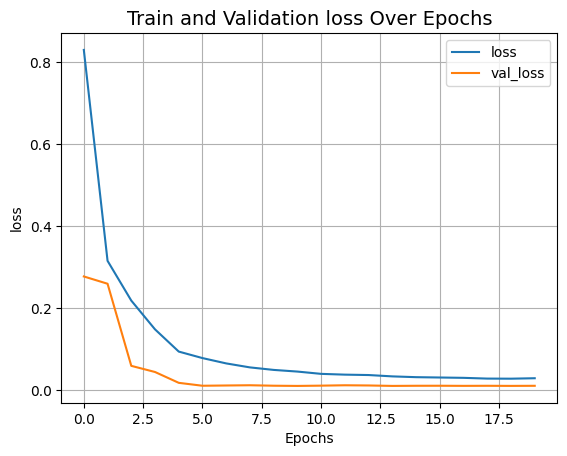

In [23]:
# Plot Train and Validation loss
def plot_history(item):
  plt.plot(history.history[item], label=item)
  plt.plot(history.history['val_' + item], label='val_' + item)
  plt.xlabel('Epochs')
  plt.ylabel(item)
  plt.title('Train and Validation {} Over Epochs'.format(item), fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()

plot_history('loss')

# Evaluate the model

In [24]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save('vit_object_detector.keras')

# To calculate IoU (Intersection over Union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
  # Get x, y co-ordinates of intersection of bounding boxes
  top_x_intersect = max(box_predicted[0], box_truth[0])
  top_y_intersect = max(box_predicted[1], box_truth[1])
  bottom_x_intersect = min(box_predicted[2], box_truth[2])
  bottom_y_intersect = min(box_predicted[3], box_truth[3])

  # Calculator area of the intersection bounding box
  intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
      0, bottom_y_intersect - top_y_intersect + 1
  )

  # Calculate area of the prediction bounding box and ground truth bounding box
  box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
      box_predicted[3] - box_predicted[1] + 1
  )
  box_truth_area = (box_truth[2] - box_truth[0] + 1) *(
      box_truth[3] - box_truth[1] + 1
  )

  # Union area
  return intersection_area / float(
      box_predicted_area + box_truth_area - intersection_area
  )

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
mean_iou: 0.7016482951473689


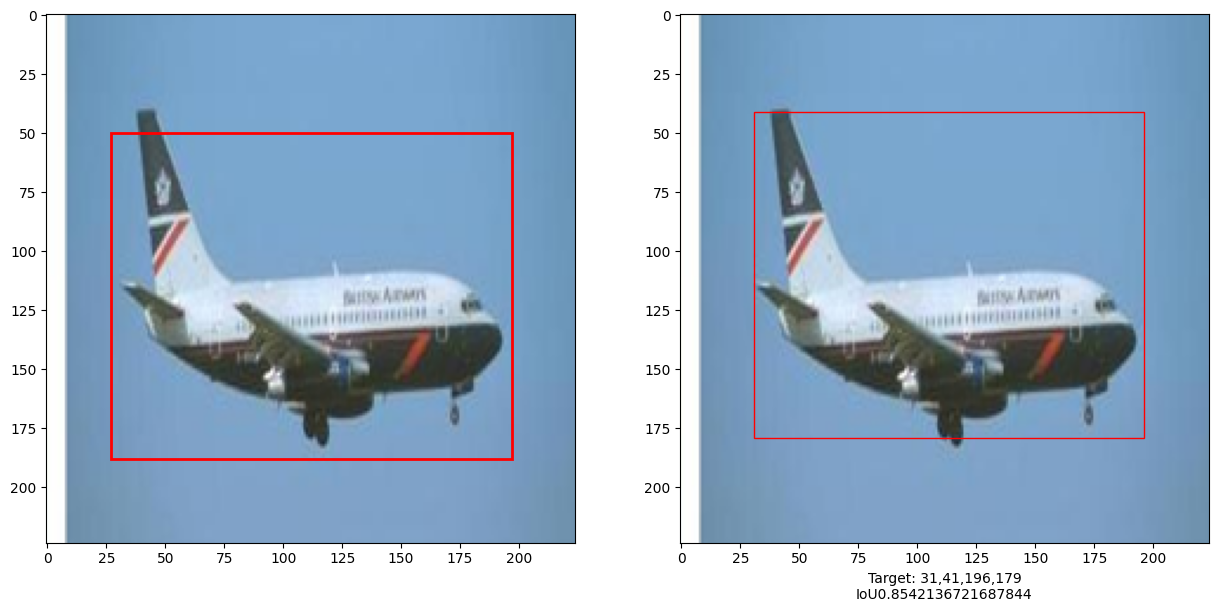

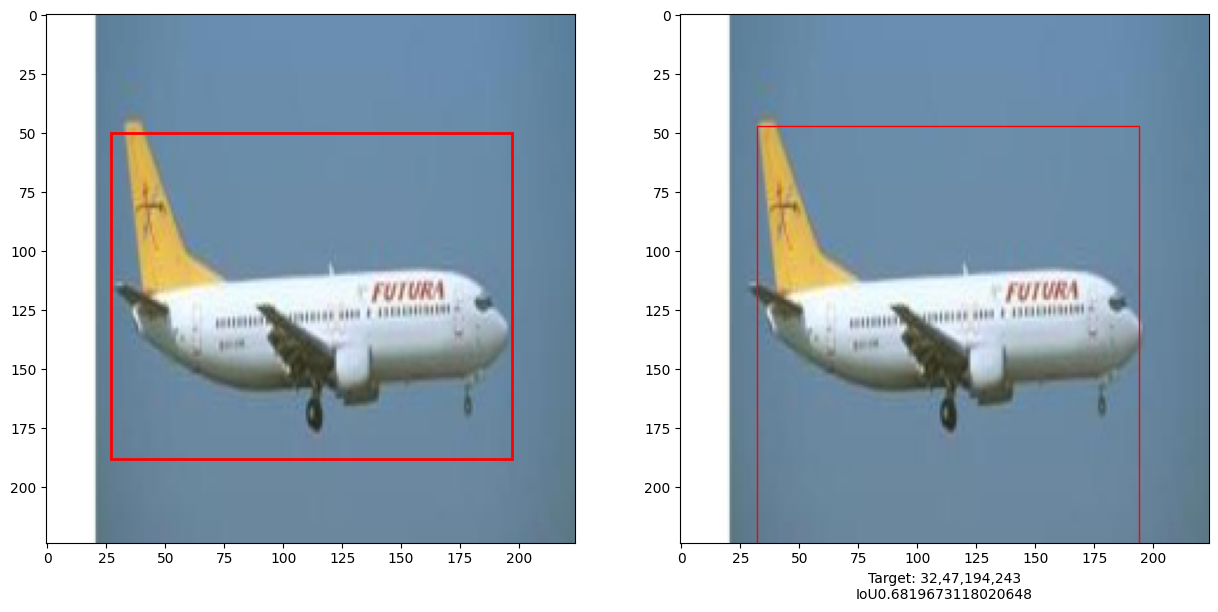

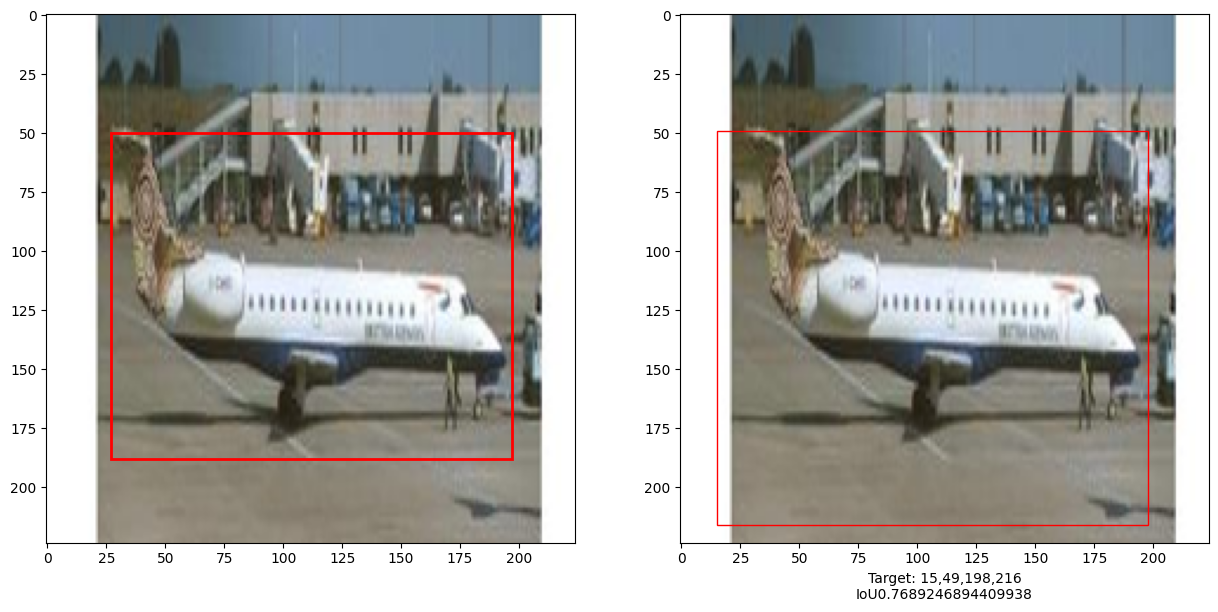

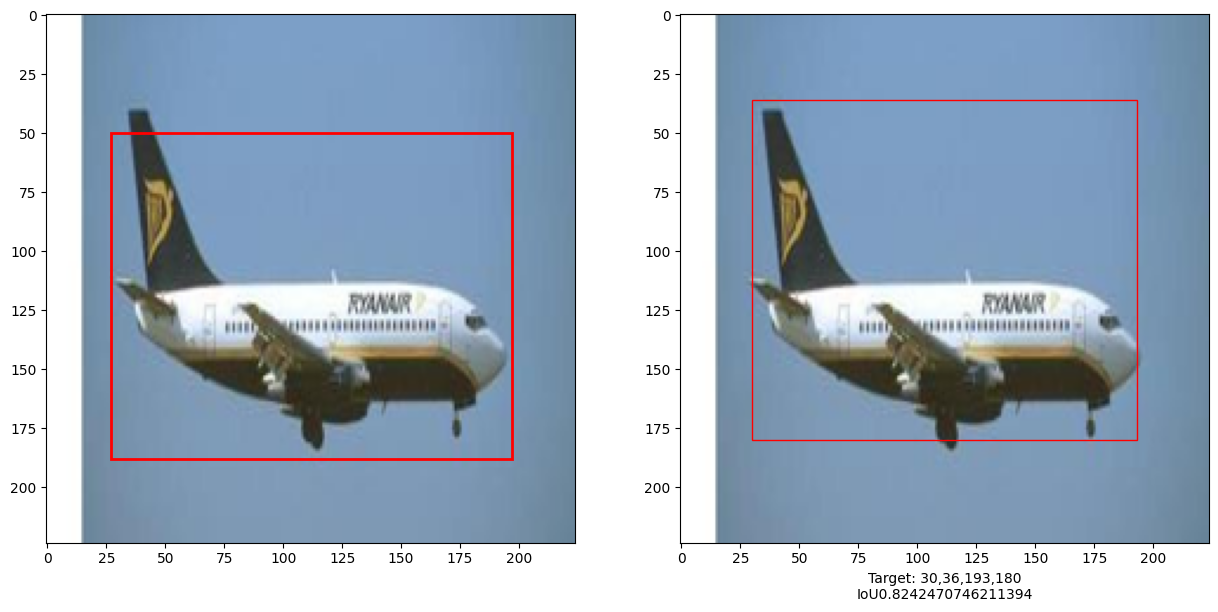

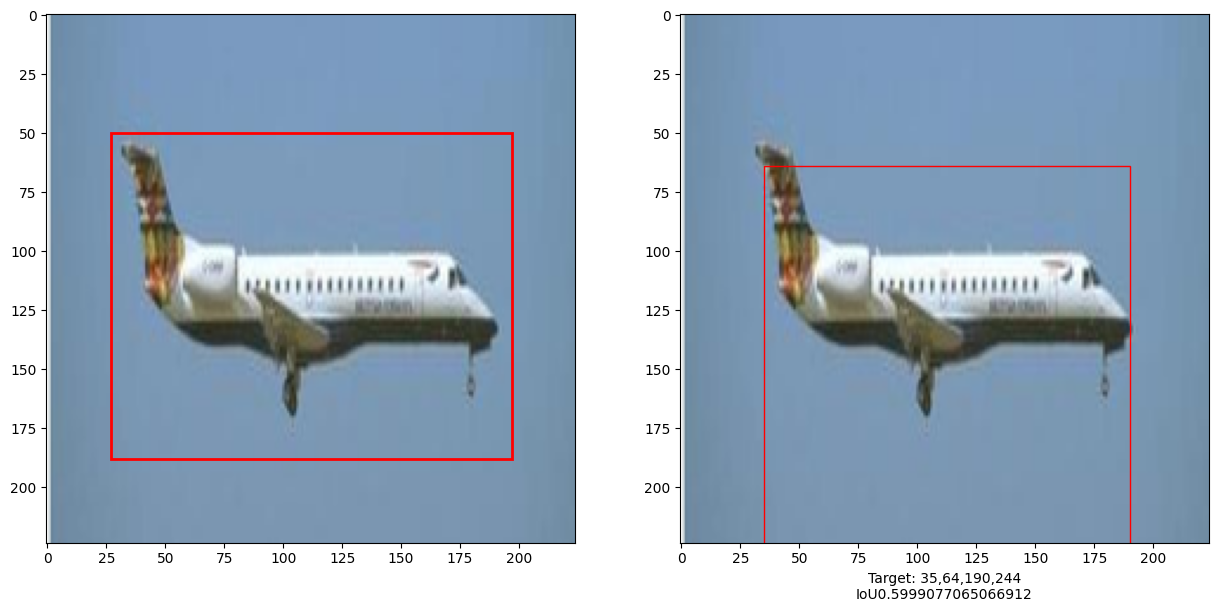

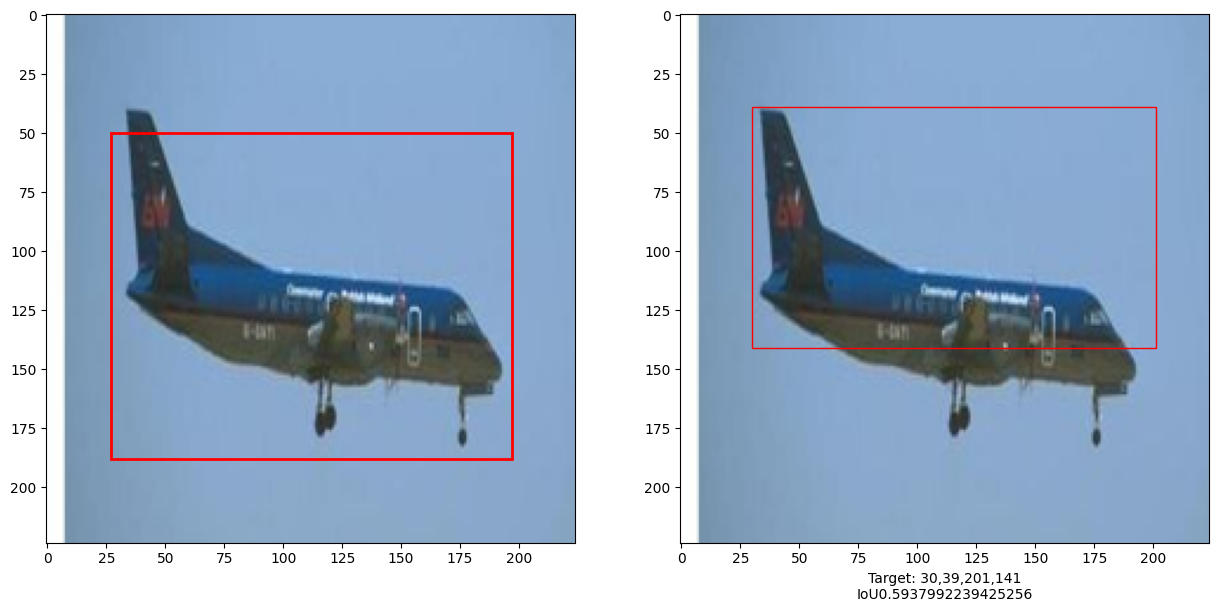

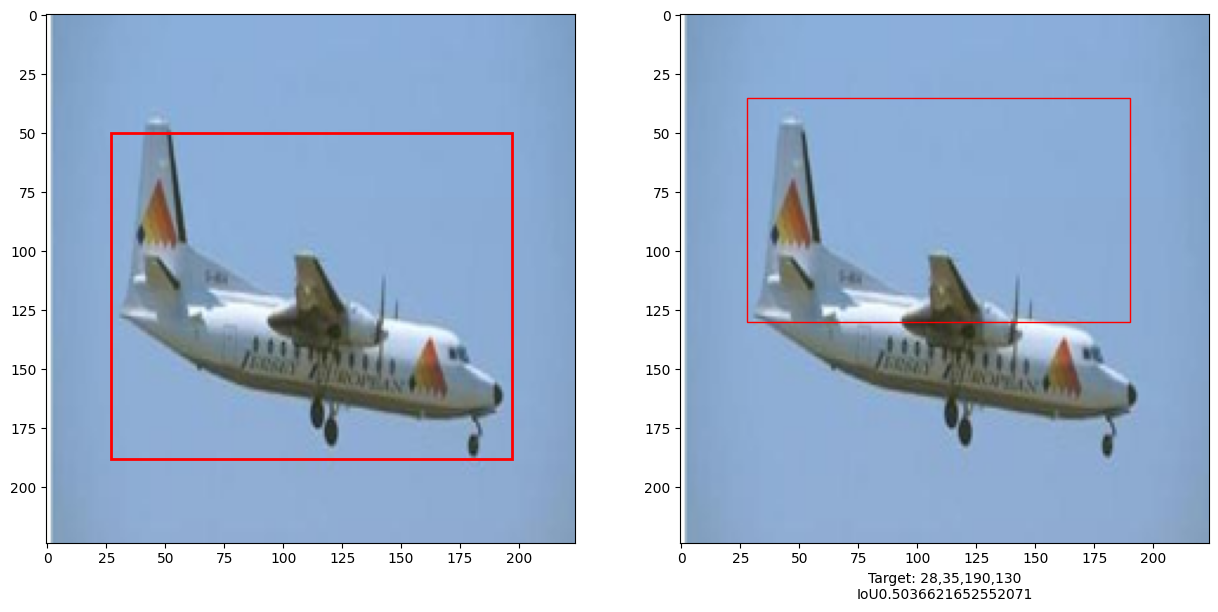

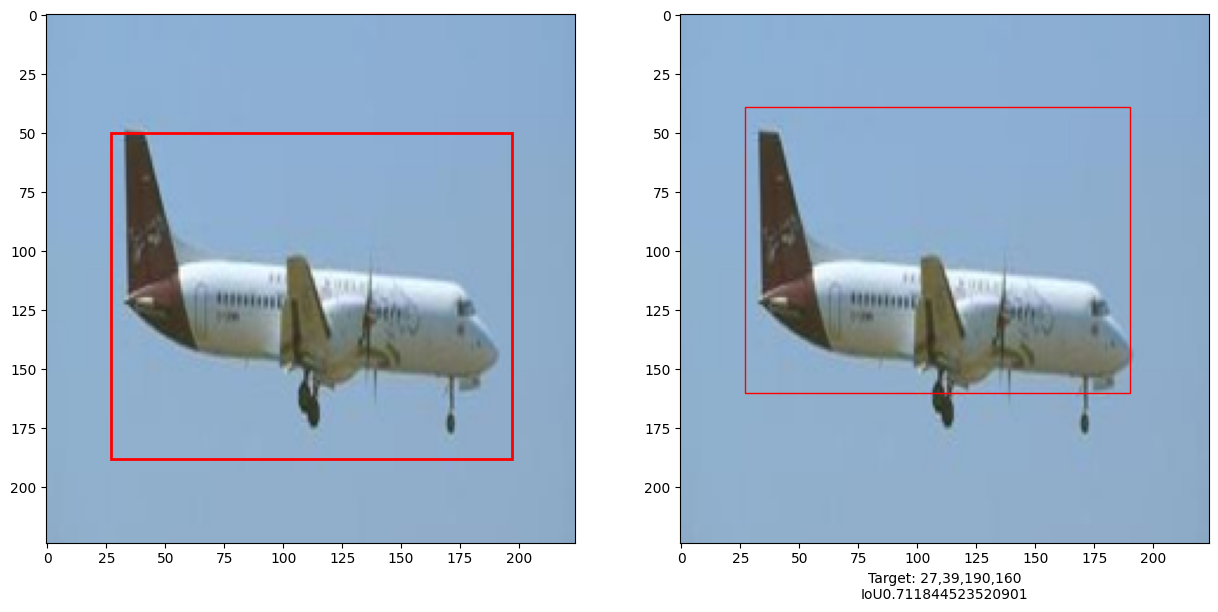

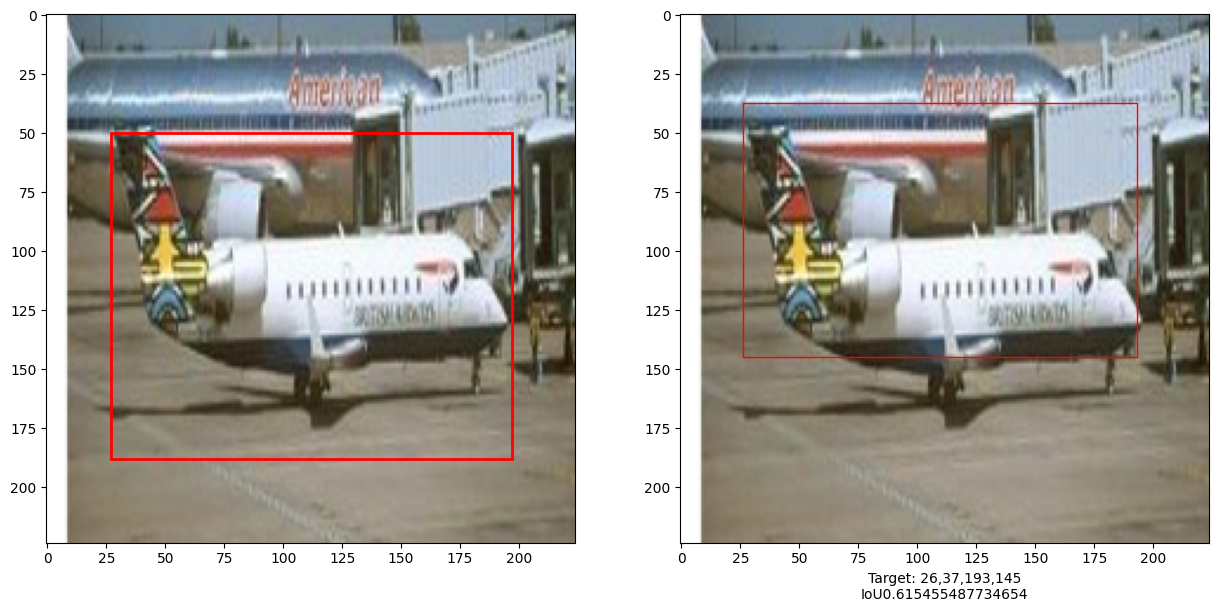

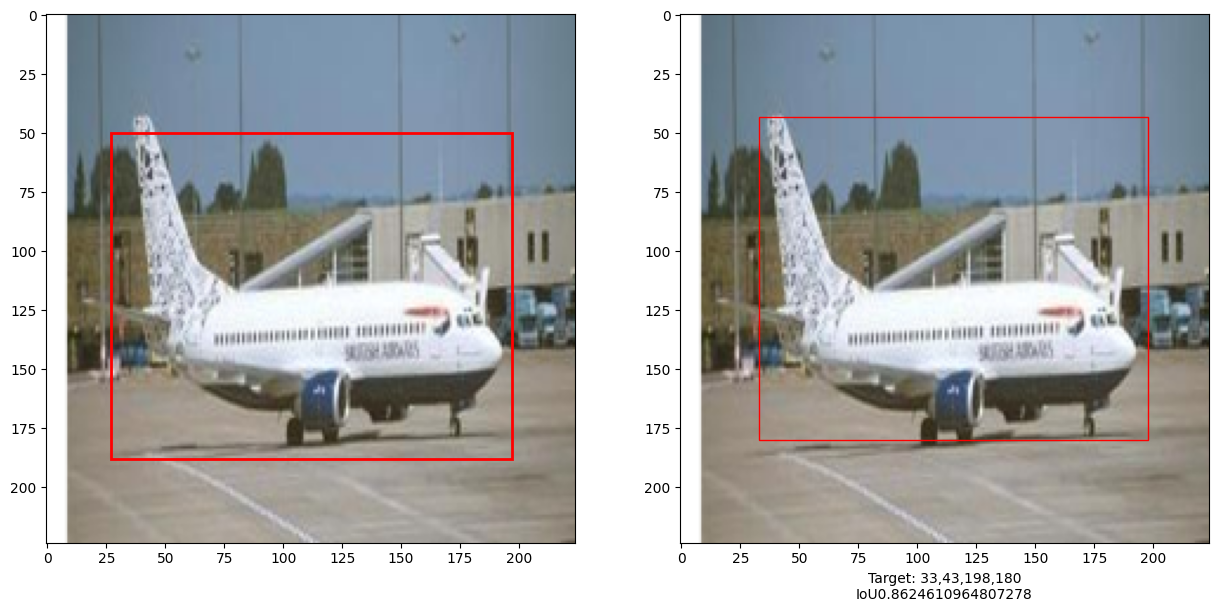

In [25]:
i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  im = input_image

  # Display the image
  ax1.imshow(im.astype('uint8'))
  ax2.imshow(im.astype('uint8'))

  input_image = cv2.resize(
      input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
  )
  input_image = np.expand_dims(input_image, axis=0)
  preds = vit_object_detector.predict(input_image)[0]

  (h, w) = (im).shape[0:2]

  top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

  bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

  box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

  # Create the bounding box
  rect = patches.Rectangle(
      (top_left_x, top_left_y),
      bottom_right_x - top_left_x,
      bottom_right_y - top_left_y,
      facecolor='none',
      edgecolor='r',
      linewidth=2,
  )

  # Add the bounding box to the image
  ax1.add_patch(rect)
  ax2.set_xlabel(
      'Predicted: '
      + str(top_left_x)
      + ','
      + str(top_left_y)
      + ','
      + str(bottom_right_x)
      + ','
      + str(bottom_right_y)
  )

  top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

  bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

  box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

  mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)

  # Create the bounding box
  rect = patches.Rectangle(
      (top_left_x, top_left_y),
      bottom_right_x - top_left_x,
      bottom_right_y - top_left_y,
      facecolor='none',
      edgecolor='red',
      linewidth=1,
  )

  # Add the bounding box to the image
  ax2.add_patch(rect)
  ax2.set_xlabel(
      'Target: '
      + str(top_left_x)
      + ','
      + str(top_left_y)
      + ','
      + str(bottom_right_x)
      + ','
      + str(bottom_right_y)
      + '\n'
      + 'IoU'
      + str(bounding_box_intersection_over_union(box_predicted, box_truth))
  )
  i = i + 1

print('mean_iou: ' + str(mean_iou / len(x_test[:10])))
plt.show()